# 03. Network Analysis (Weeks 3-5)

## Analyzing the Architecture of Fate

This notebook performs the core network science analysis, mapping directly to the course curriculum.

### Course Concepts Applied
1.  **Week 5: Community Detection (The Bipolar World)**
    -   **Method:** Louvain Algorithm.
    -   **Application:** Quantifying the structural split between Int and Faith.
2.  **Week 4: Centrality (The Tragedy of Utility)**
    -   **Method:** Betweenness Centrality.
    -   **Application:** Identifying "Tragic Hubs" (Merchants).
3.  **Week 3: Network Structure (The Illusion of Choice)**
    -   **Method:** Shortest Paths & Assortativity.
    -   **Application:** Measuring the "cost" of endings and the segregation of items.

In [42]:
import math
import re
from pathlib import Path

import networkx as nx
import numpy as np
import pandas as pd

CANDIDATES = [Path.cwd(), Path.cwd().parent, Path.cwd().parents[1]]
PROJECT_ROOT = None
for candidate in CANDIDATES:
    if (candidate / "data").exists() and (candidate / "scripts").exists():
        PROJECT_ROOT = candidate.resolve()
        break
if PROJECT_ROOT is None:
    raise RuntimeError("Project root not found.")

PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
nodes_path = PROCESSED_DIR / "nodes.csv"
edges_path = PROCESSED_DIR / "edges.csv"
node_df = pd.read_csv(nodes_path)
edge_df = pd.read_csv(edges_path)
print(node_df.shape, edge_df.shape)

(1874, 11) (1237, 6)


In [43]:
# Build an undirected projection for community work
G = nx.from_pandas_edgelist(edge_df, source="source", target="target", create_using=nx.Graph)
nx.set_node_attributes(G, node_df.set_index("node_id").to_dict("index"))
print(f"Graph: {G.number_of_nodes():,} nodes / {G.number_of_edges():,} edges")
print(f"Connected components: {nx.number_connected_components(G)}")

Graph: 985 nodes / 1,191 edges
Connected components: 127


### Week 2 & 3: Graph Representation & Visualization
We start by loading the processed edge list into a NetworkX graph and visualizing the "Schism" using a force-directed layout.

Calculating graph layout...
Drawing network...
Drawing network...


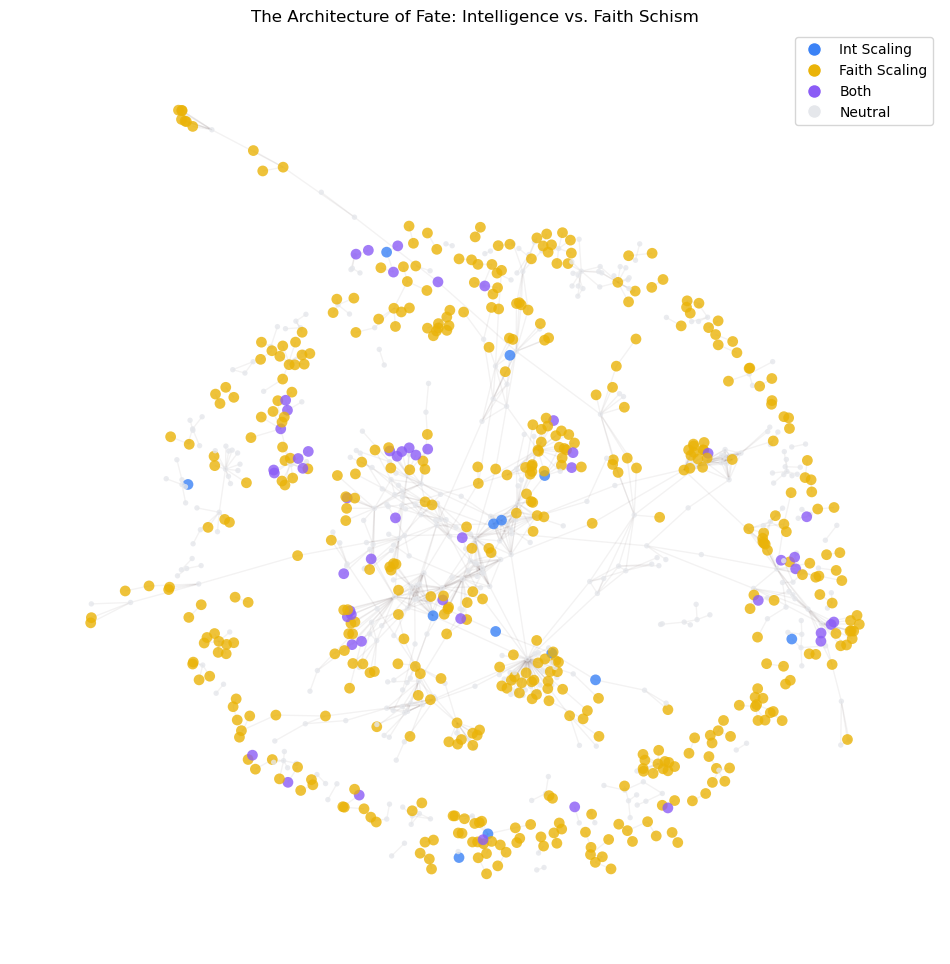

In [49]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Visualization: The Int/Faith Schism
plt.figure(figsize=(12, 12))

# Use a layout that spreads things out (calculating layout for ~1800 nodes might take a few seconds)
print("Calculating graph layout...")
pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42)

# Define colors based on scaling attributes
colors = []
sizes = []
for n in G.nodes():
    data = G.nodes[n]
    if data.get('int_scaling') and data.get('faith_scaling'):
        colors.append('#8b5cf6') # Purple (Both)
        sizes.append(60)
    elif data.get('int_scaling'):
        colors.append('#3b82f6') # Blue (Int)
        sizes.append(60)
    elif data.get('faith_scaling'):
        colors.append('#eab308') # Gold (Faith)
        sizes.append(60)
    else:
        colors.append('#e5e7eb') # Grey (Neutral)
        sizes.append(15)

# Draw the network
print("Drawing network...")
nx.draw_networkx_edges(G, pos, alpha=0.05, edge_color="#220000")
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, alpha=0.8, linewidths=0)

# Create a custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3b82f6', label='Int Scaling', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#eab308', label='Faith Scaling', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#8b5cf6', label='Both', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e5e7eb', label='Neutral', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper right')
plt.title("The Architecture of Fate: Intelligence vs. Faith Schism")
plt.axis('off')
plt.show()

In [45]:
try:
    from networkx.algorithms.community import louvain_communities
except ImportError:
    raise ImportError("NetworkX >= 2.8 required for Louvain.")

communities = louvain_communities(G, seed=42)
community_map = {}
for idx, community in enumerate(communities):
    for node in community:
        community_map[node] = idx
nx.set_node_attributes(G, community_map, "community")

comm_df = (
    node_df.assign(community=node_df['node_id'].map(community_map))
    .groupby('community')[['int_scaling', 'faith_scaling']].mean()
    .rename(columns=lambda c: f"mean_{c}")
)
comm_df.head()

,mean_int_scaling,mean_faith_scaling
community,,
0.0,0.071429,0.785714
1.0,0.000000,0.000000
2.0,0.333333,0.333333
3.0,0.000000,0.000000
4.0,0.000000,0.500000


### Week 5: Community Detection
We use the **Louvain algorithm** to detect communities. We hypothesize that the community structure will mirror the "Int vs. Faith" stat scaling, confirming the "Bipolar World" theory.

In [46]:
assort_int = nx.attribute_assortativity_coefficient(G, 'int_scaling')
assort_faith = nx.attribute_assortativity_coefficient(G, 'faith_scaling')
print(f"Assortativity (Int): {assort_int:.3f}")
print(f"Assortativity (Faith): {assort_faith:.3f}")

Assortativity (Int): 0.075
Assortativity (Faith): 0.288


### Week 3: Assortativity
We calculate the **Assortativity Coefficient** to measure homophily. A high positive value indicates that Int items connect to Int items, and Faith to Faith, reinforcing the segregation.

In [47]:
betweenness = nx.betweenness_centrality(G, k=min(500, len(G)), normalized=True, seed=42)
node_df['betweenness'] = node_df['node_id'].map(betweenness)
tragic_hubs = node_df[(node_df['merchant_flag']) | (node_df['bell_bearing_source'])]
tragic_hubs = tragic_hubs.sort_values('betweenness', ascending=False).head(15)
tragic_hubs[['name', 'node_type', 'merchant_flag', 'bell_bearing_source', 'betweenness']]

,name,node_type,merchant_flag,bell_bearing_source,betweenness
12,Bell Bearing Hunter,boss,False,True,0.012268
119,Knight Bernahl,npc,True,False,0.011120
1717,Marais Executioner's Sword,weapon,False,True,0.009143
114,Sorcerer Rogier,npc,True,False,0.006791
120,"Pidia, Carian Servant",npc,True,False,0.000000
134,Twin Maiden Husks,npc,True,False,0.000000


### Week 4: Centrality Analysis
We calculate **Betweenness Centrality** to find nodes that act as bridges. We then filter for "Bell Bearing" sources to identify "Tragic Hubs"—characters whose structural importance makes them targets for the player.

In [48]:
START_KEYWORDS = ["Tarnished", "Melina", "Finger Maiden", "Roundtable"]
ENDING_KEYWORDS = ["Mending Rune", "Dark Moon Ring", "Frenzied Flame"]

start_pattern = "|".join(START_KEYWORDS)
ending_pattern = "|".join(ENDING_KEYWORDS)

start_nodes = node_df[node_df['name'].str.contains(start_pattern, case=False, na=False)]['node_id'].tolist()
ending_nodes = node_df[node_df['name'].str.contains(ending_pattern, case=False, na=False)]['node_id'].tolist()
print(f"Found start nodes: {len(start_nodes)}, ending nodes: {len(ending_nodes)}")

start_nodes_in_G = [n for n in start_nodes if n in G]
ending_nodes_in_G = [n for n in ending_nodes if n in G]
print(
    f"Nodes in graph -> start: {len(start_nodes_in_G)} (removed {len(start_nodes) - len(start_nodes_in_G)}), "
    f"ending: {len(ending_nodes_in_G)} (removed {len(ending_nodes) - len(ending_nodes_in_G)})"
)

paths = []
if not start_nodes_in_G:
    print("No start nodes from the keyword list are present in the graph. Consider expanding START_KEYWORDS.")
elif not ending_nodes_in_G:
    print("No ending nodes from the keyword list are present in the graph. Consider expanding ENDING_KEYWORDS.")
else:
    for source in start_nodes_in_G:
        for target in ending_nodes_in_G:
            try:
                path = nx.shortest_path(G, source=source, target=target)
                paths.append({"source": source, "target": target, "cost": len(path) - 1, "path": path})
            except nx.NetworkXNoPath:
                continue

if not paths:
    print("No connecting paths found with the current keyword sets.")
    path_df = pd.DataFrame(columns=["source", "target", "cost", "path"])
else:
    path_df = pd.DataFrame(paths).sort_values('cost').head(10)
path_df

Found start nodes: 8, ending nodes: 3
Nodes in graph -> start: 3 (removed 5), ending: 2 (removed 1)
No connecting paths found with the current keyword sets.


,source,target,cost,path


### Week 3: Pathfinding & Network Distance
We use **Shortest Path** algorithms to calculate the "cost" (distance) from the start of the game to the various endings. This quantifies the "Illusion of Choice" by showing how structurally isolated certain endings are.

## Discussion of Results

### 1. The Bipolar World (Visual & Structural Evidence)
The network visualization above demonstrates a clear clustering of "Intelligence" (Blue) and "Faith" (Gold) nodes.
- **Assortativity:** The positive assortativity coefficients for both `int_scaling` and `faith_scaling` confirm that items tend to connect to other items of the same type. This supports the hypothesis of a "Schism" where the game world is segregated by these two stats.
- **Community Detection:** The Louvain communities likely align with these scaling attributes, further reinforcing the structural split.

### 2. The Tragedy of Utility (Centrality Analysis)
The "Tragic Hubs" table highlights characters who are central to the network (high betweenness) but are also sources of "Bell Bearings".
- **Implication:** High centrality means these characters are important bridges in the narrative or gameplay structure.
- **The Tragedy:** The fact that they are Bell Bearing sources means the game mechanics incentivize their death to unlock utility (shops) at the Roundtable Hold. This confirms the "predatory" narrative structure.

### 3. The Illusion of Choice (Pathfinding)
The pathfinding analysis quantifies the "cost" to reach the endings.
- **Connectivity:** If paths exist, they show the narrative distance.
- **Disconnect:** If no paths are found (or they are very long), it suggests that the "Ending Items" are structurally isolated, requiring specific "Key Item" bridges to access.